# Analyze NFL Play Type by team

<font color = black > The goal of the analysis will be to analyze the play calling of the Kansas City Chiefs football team. 

1. Download 2018 nfl play calling data from github
2. Review data to identify important data fields for analysis
3. Analyze pass play tendancy based on the down and distance of the KC Chiefs vs all NFL teams
4. Determine which NFL teams have the most pass-heavy play calling
5. Fit and test machine learning model to data to predict play type


 </font>

## Step 1: download nfl play calling data from github

In [2]:
import pandas as pd # data manipulation library
import numpy as np # numerical computation library
import datetime as dt 

import matplotlib.pyplot as plt # plotting library
from matplotlib import cm # color maps for plotting
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
plt.style.use('ggplot') # use the ggplot plotting style


nfl = pd.read_csv('https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/play_by_play_data/regular_season/reg_pbp_2018.csv', low_memory=False,error_bad_lines=False)

## Step 2: Review data to identify important data fields for analysis

In [3]:
bins = [0, 2, 5, 9.99,10, 15, np.inf]
names = ['<2', '2-5', '6-9', '10', '11-14','15+']

nfl['ydstogo_label'] = pd.cut(nfl['ydstogo'], bins=bins, labels=names)

chiefs = nfl.loc[nfl['posteam'] == "KC"]

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

useful columns appear to be as follows: 

| Column | Description |
| --------------- | ----------- |
| ydstogo_label | e.g. <2, 2-5, 5-8, 8-9, 10 10-15, 15+|
| play_type	 | no_play, pass, kickoff, run|
| down | NaN, 0, 1, 2, 3,4|
| yardline_100	 | 1-99 with numbers > 50 on home side of field |
|posteam | team with possession|
|qtr | Quarter|
|time| Time remaining in quarter|

## Step 3: Analyze pass play tendancy of the KC Chiefs vs all NFL teams

In [5]:
chiefs_runpassonly = chiefs[chiefs['play_type'].isin(['run','pass'])]
nfl_runpassonly = nfl[nfl['play_type'].isin(['run','pass'])]
pd.crosstab(chiefs_runpassonly.down,chiefs_runpassonly.play_type,margins = True, normalize='index')


play_type,pass,run
down,,
1.0,0.552239,0.447761
2.0,0.644860,0.355140
3.0,0.760000,0.240000
4.0,0.400000,0.600000
All,0.617347,0.382653


In [6]:
pd.crosstab(nfl_runpassonly.down,nfl_runpassonly.play_type,margins = True, normalize='index')

play_type,pass,run
down,,
1.0,0.506966,0.493034
2.0,0.592352,0.407648
3.0,0.785636,0.214364
4.0,0.639098,0.360902
All,0.593548,0.406452


> **Finding: Chiefs are more likely to call Pass Plays for all downs (61.7% vs 59.4%). Let's now look at play data based on down and distance**

In [7]:
chiefs_temp = pd.crosstab(chiefs_runpassonly.ydstogo_label,[chiefs_runpassonly.play_type,chiefs_runpassonly.down],normalize='index')
chiefs_temp2 = pd.crosstab(chiefs_runpassonly.ydstogo_label,chiefs_runpassonly.down,normalize='index')
chiefs_crosstab_play=chiefs_temp/chiefs_temp2
nfl_temp = pd.crosstab(nfl_runpassonly.ydstogo_label,[nfl_runpassonly.play_type,nfl_runpassonly.down],normalize='index')
nfl_temp2 = pd.crosstab(nfl_runpassonly.ydstogo_label,nfl_runpassonly.down,normalize='index')
nfl_crosstab_play=nfl_temp/nfl_temp2
chiefs_crosstab_play 

play_type          pass                                     run            \
down                1.0       2.0       3.0       4.0       1.0       2.0   
ydstogo_label                                                               
<2             0.300000  0.416667  0.513514  0.272727  0.700000  0.583333   
2-5            0.428571  0.615385  0.842105  0.500000  0.571429  0.384615   
6-9            0.583333  0.686047  0.734694  1.000000  0.416667  0.313953   
10             0.555012  0.670455  0.954545       NaN  0.444988  0.329545   
11-14          0.500000  0.735294  0.809524       NaN  0.500000  0.264706   
15+            0.909091  0.750000  1.000000       NaN  0.090909  0.250000   

play_type                          
down                3.0       4.0  
ydstogo_label                      
<2             0.486486  0.727273  
2-5            0.157895  0.500000  
6-9            0.265306  0.000000  
10             0.045455       NaN  
11-14          0.190476       NaN  
15+            0.000000       NaN

In [8]:
nfl_crosstab_play

play_type          pass                                     run            \
down                1.0       2.0       3.0       4.0       1.0       2.0   
ydstogo_label                                                               
<2             0.304933  0.347505  0.432304  0.406475  0.695067  0.652495   
2-5            0.452229  0.488372  0.854447  0.857143  0.547771  0.511628   
6-9            0.397015  0.640568  0.889070  0.893939  0.602985  0.359432   
10             0.506940  0.625427  0.889085  0.884615  0.493060  0.374573   
11-14          0.620968  0.753029  0.898305  1.000000  0.379032  0.246971   
15+            0.716814  0.722513  0.804825  1.000000  0.283186  0.277487   

play_type                          
down                3.0       4.0  
ydstogo_label                      
<2             0.567696  0.593525  
2-5            0.145553  0.142857  
6-9            0.110930  0.106061  
10             0.110915  0.115385  
11-14          0.101695  0.000000  
15+            0.195175  0.000000

> **Summary of play pass tendancy on more common down and distance scenarios:**

| Down & Distance | Chiefs Pass % | NFL Pass % |
| --------------- | ----------- | ----------- |
| 1st & 10   | 55.5%    | 50.6% |
| 2nd & 10	 | 67.0% | 62.5% | 
| 2nd & 5    | 61.5% | 48.8% | 
| 2nd & 1	 | 41.7% | 34.7% | 
| 3rd & 10	 | 95.5% | 88.9% | 
| 3rd & 5    | 84.2% | 85.4% | 
| 3rd & 1	 | 51.3% | 43.2% | 

The chiefs call more pass plays than the average NFL team for all down/distance scenarios exccept 3rd & 5

2nd down & 5 yards is a scenario the Chiefs like to call pass plays and they do so at a much higher rate than the average NFL team (Chiefs 61.5% vs NFL team of 48.8%) 

Run plays are more likely in short yardage especially on 3rd down scenarios. However, even in 3rd and short the Chiefs are more likely to call pass plays (51%). 



## Step 4: Which NFL teams are the most pass-heavy

In [9]:
pd.crosstab(nfl_runpassonly.posteam,nfl_runpassonly.play_type,margins = True, normalize='index').sort_values(by='run').head(10)

play_type,pass,run
posteam,,
PIT,0.682646,0.317354
GB,0.677483,0.322517
ATL,0.658052,0.341948
MIN,0.650602,0.349398
NYG,0.643655,0.356345
TB,0.636711,0.363289
IND,0.630975,0.369025
CIN,0.620022,0.379978
PHI,0.619279,0.380721


> **The Chiefs are the 10th most pass heavy team in the NFL**

## Step 5: Fit and Test Machine Learning Models to Chiefs Play Type

In [10]:
#extract features and target variables
chiefs_runpassonly.dropna(subset = ['down'], inplace = True)
x = chiefs_runpassonly[['ydstogo','down','yardline_100','game_seconds_remaining']]
y = chiefs_runpassonly['play_type']
labels = y.unique()
feature_names = x.columns

<ipython-input-10-924535b0b4db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chiefs_runpassonly.dropna(subset = ['down'], inplace = True)


In [11]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state=42)

In [12]:
model = DecisionTreeClassifier(max_depth = 4, random_state=42)
model.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

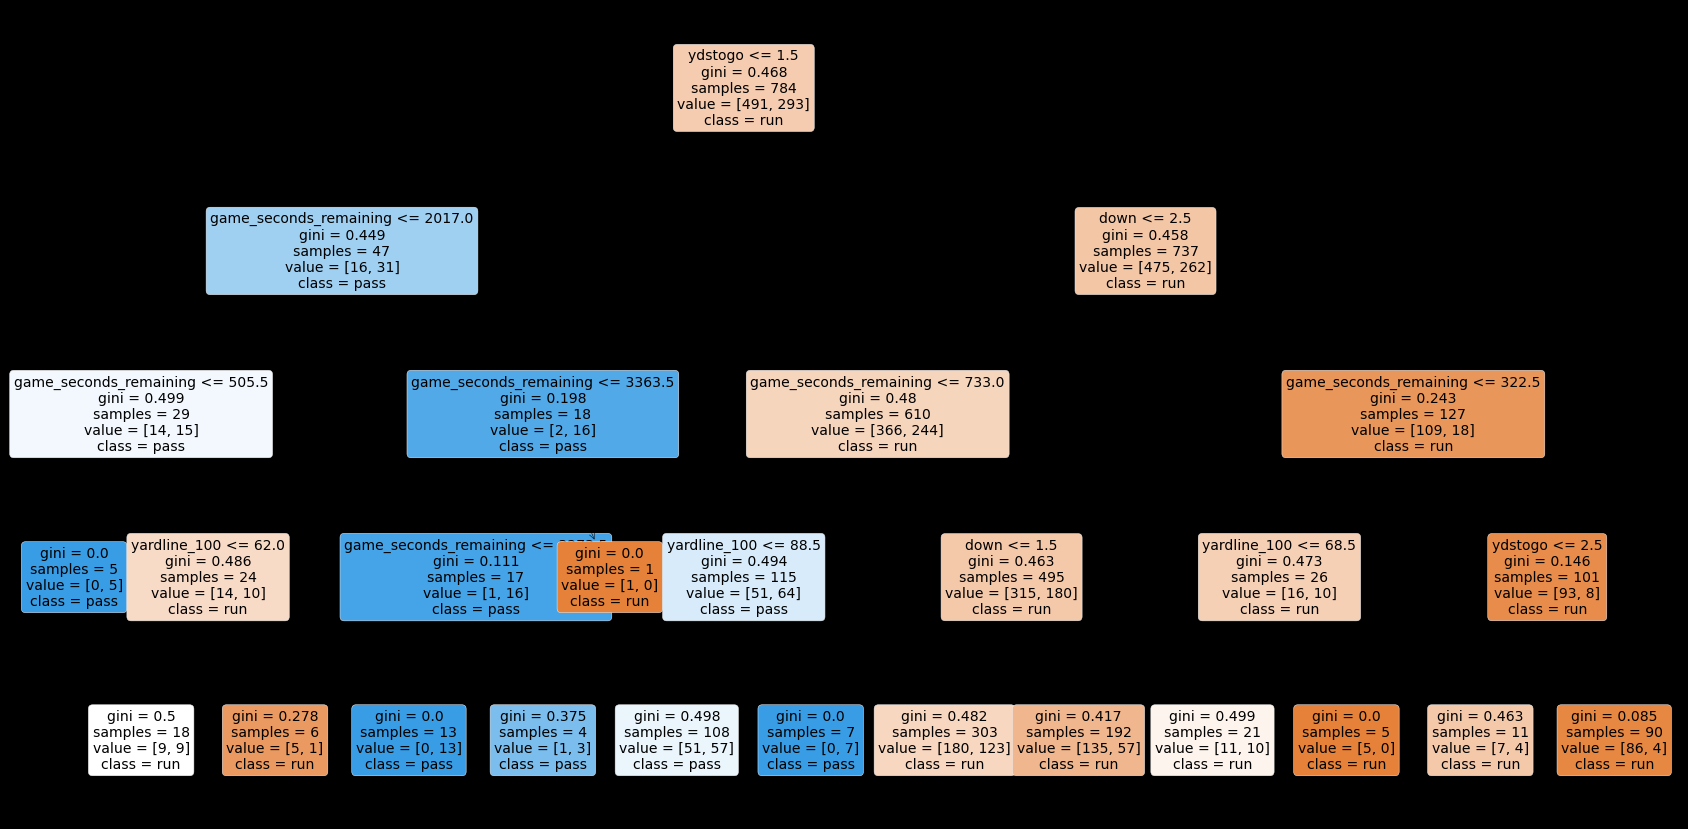

In [13]:
from sklearn import tree
plt.figure(figsize = (30,15),facecolor='k')
a = tree.plot_tree(model,feature_names = feature_names,class_names=labels,rounded=True,filled=True,fontsize=14)

In [14]:
test_pred_decision_tree = model.predict(x_test)
predictions_df = pd.DataFrame(test_pred_decision_tree)
predictions_df.describe()

,0
count,196
unique,2
top,pass
freq,154


In [15]:
y_test_df = pd.DataFrame(y_test)
y_test_df.describe()

,play_type
count,196
unique,2
top,pass
freq,114


In [16]:
from sklearn import metrics
import seaborn as sns

confusion_matrix = metrics.confusion_matrix(y_test_df,predictions_df)

matrix_df=pd.DataFrame(confusion_matrix)
matrix_df

,0,1
0,95,19
1,59,23


<function matplotlib.pyplot.show(close=None, block=None)>

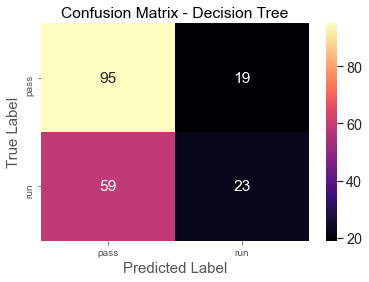

<Figure size 720x504 with 0 Axes>

In [17]:
ax = plt.axes()
sns.set(font_scale = 1.3)
plt.figure(figsize = (10,7))
sns.heatmap(matrix_df, annot=True,fmt="g", ax = ax, cmap = "magma")

ax.set_title('Confusion Matrix - Decision Tree')
ax.set_xlabel("Predicted Label",fontsize = 15)
ax.set_xticklabels(['pass','run'])
ax.set_ylabel("True Label", fontsize=15)
ax.set_yticklabels(['pass','run'])

plt.show

In [18]:
metrics.accuracy_score(y_test_df,predictions_df)

0.6020408163265306